In [1]:
%env CUDA_VISIBLE_DEVICES=0,1
# %env XLA_FLAGS="--xla_force_host_platform_device_count=8"

env: CUDA_VISIBLE_DEVICES=''
env: XLA_FLAGS="--xla_force_host_platform_device_count=8"


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as onp

import jax
from jax import vmap
import jax.numpy as np
import jax.random as random

import numpyro
from numpyro import handlers
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from scipy.stats import norm

import os, sys
sys.path.append(os.path.split(os.getcwd())[0])
import scripts.transform_data as transform
import models.SIR as SIR

In [3]:
plt.rcParams['font.size'] = 14

In [4]:
N_GPU = sum([i.isdigit() for i in os.environ.get('CUDA_VISIBLE_DEVICES')])
if N_GPU>0:
    numpyro.set_platform('gpu')   
    numpyro.set_host_device_count(N_GPU)
    N_chains = N_GPU
else:
    numpyro.set_host_device_count(8)
    N_chains = 8

print(jax.devices())    

[CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3), CpuDevice(id=4), CpuDevice(id=5), CpuDevice(id=6), CpuDevice(id=7)]


# Process Data

In [5]:
# Confirmed, Recovered and Death Cases
IRD = transform.IRD(min_confirmed=100, min_recovered=0, min_deaths=0)

In [6]:
min_days = 14
cases = {}
recoveries = {}
deaths = {}
start_days = np.argmax((IRD[0].values>=70),axis=1)
for i, country in enumerate(IRD[0].index):
    if len(IRD[0].T[country].values[start_days[i]:])>=min_days:
        cases[country] = np.array(IRD[0].T[country].values[start_days[i]:]).astype(np.float32)
        recoveries[country] = np.array(IRD[1].T[country].values[start_days[i]:]).astype(np.float32)
        deaths[country] = np.array(IRD[2].T[country].values[start_days[i]:]).astype(np.float32)

In [ ]:
pops = transform.population()

In [ ]:
len(cases), len(IRD[0])

Text(0, 0.5, 'Cumulative Death Cases')

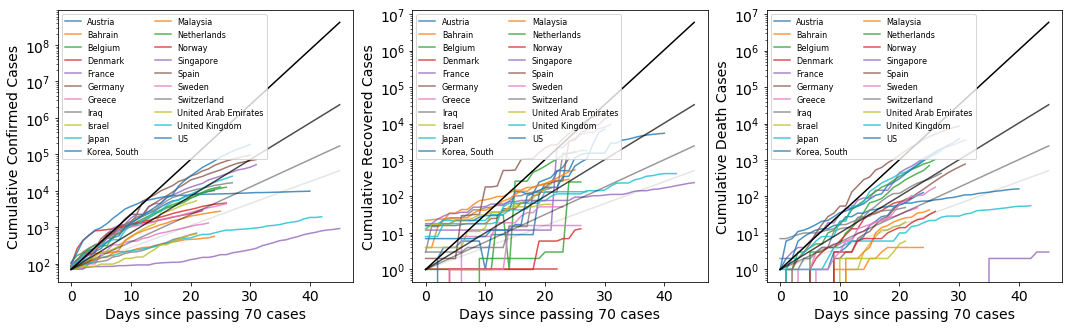

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
t = np.arange(np.max([len(cases[c]) for c in cases.keys()]))
for i, c in enumerate(cases.keys()):
    if len(cases[c])>21:
        ax[0].semilogy(cases[c], alpha = 0.8, label=c)
        ax[1].semilogy(recoveries[c], alpha = 0.8, label=c)
        ax[2].semilogy(deaths[c], alpha = 0.8, label=c)

for [a, start] in zip(ax, [70, 1, 1]):
    a.set_xlabel('Days since passing 70 cases')
    a.legend(ncol=2, fontsize=8)
    for i in range(2, 6):
        a.semilogy(t, start*(2.0**(1.0/float(i)))**t, 'k', alpha=1.0-(i-2)*0.3, label=f'DR: {i} days')

ax[0].set_ylabel('Cumulative Confirmed Cases')
ax[1].set_ylabel('Cumulative Recovered Cases')
ax[2].set_ylabel('Cumulative Death Cases')

In [10]:
def normalHP(name, mean, std, N_child):

    # Group mean
    grp_mean = numpyro.sample(str(name)+'_grp_mean', dist.Normal(100.0, 50.0))
    # Group variance
    grp_sigma = numpyro.sample(str(name)+'_grp_sigma', dist.HalfNormal(50.0))
    # Individual param
    ind = numpyro.sample(str(name)+'_ind', dist.Normal(grp_mean*np.ones(N_child), grp_sigma*np.ones(N_child)))
    
    return ind

In [11]:
def halfnormHP(name, mean, std, N_child):
    
    # Group mean
    grp_mean = numpyro.sample(str(name)+'_grp_mean', dist.HalfNormal(mean))
    # Group variance
    grp_sigma = numpyro.sample(str(name)+'_grp_sigma', dist.HalfNormal(std))
    # Individual param
    ind = numpyro.sample(str(name)+'_ind', dist.Normal(grp_mean*np.ones(N_child), grp_sigma*np.ones(N_child)))
    
    return ind

In [12]:
def model():
    
    N = len(cases)
    
    ############  
    # Initial Infection Rate
    Ii = normalHP('Ii', 100.0, 50.0, N)
    # Initial Removed Rate
    Ri = normalHP('Ri', 10.0, 5.0, N)
    # beta
    beta = halfnormHP('beta', 0.1, 0.05, N)
    # gamma
    gamma = halfnormHP('gamma', 0.05, 0.03, N)
    
    # Create likelihood for each country
    for i, country in enumerate(list(cases.keys())):
        
        N_pop = pops.T[country].values[0]
        N_days = len(cases[country])
        observation = [cases[country], recoveries[country]+deaths[country]]
        prediction = SIR.SIR(N_pop, Ii[i], Ri[i], beta[i], gamma[i], N_days)
        
        # Likelihood
        for i in range(1, 3):
            numpyro.sample(country+str(i), dist.Poisson(prediction[:,i]), # SIR model
                           obs=observation[i-1])

In [13]:
N = len(cases)          
init_params = {'Ii_grp_mean': 100.0*np.ones((N_chains, 1)),
               'Ii_grp_sigma': 0.1*np.ones((N_chains, 1)),
               'Ii_ind': 100.0*np.ones((N_chains, N)),
               'Ri_grp_mean': 10.0*np.ones((N_chains, 1)),
               'Ri_grp_sigma': 0.1*np.ones((N_chains, 1)),
               'Ri_ind': 10.0*np.ones((N_chains, N)),
               'beta_grp_mean': 0.1*np.ones((N_chains, 1)),
               'beta_grp_sigma': 0.001*np.ones((N_chains, 1)),
               'beta_ind': 0.1*np.ones((N_chains, N)),
               'gamma_grp_mean': 0.05*np.ones((N_chains, 1)),
               'gamma_grp_sigma': 0.001*np.ones((N_chains, 1)),
               'gamma_ind': 0.05*np.ones((N_chains, N))
               }
if N_chains==1:
    for key in init_params.keys():
        init_params[key] = init_params[key][0]

nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000, num_chains=N_chains)
rng_key = random.PRNGKey(0)

In [ ]:
mcmc.run(rng_key, extra_fields=('potential_energy',), init_params=init_params)

/tf/numpyro/numpyro/infer/mcmc.py:1186: UserWarning: There are not enough devices to run parallel chains: expected 8 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider to use `numpyro.set_host_device_count(8)` at the beginning of your program.
  .format(self.num_chains, xla_bridge.device_count(), self.num_chains))


In [21]:
samples = mcmc.get_samples()
mcmc.print_summary()


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
 Ii_grp_mean[0]    175.05     26.25    174.19    135.48    213.22      9.92      1.31
Ii_grp_sigma[0]    254.19     16.57    253.38    224.54    278.36   2865.46      1.00
      Ii_ind[0]     91.06      3.67     90.83     85.06     97.21     15.47      1.20
      Ii_ind[1]    112.61      3.79    112.62    105.88    118.32    154.98      1.01
      Ii_ind[2]     97.78      4.89     98.37     90.42    105.68      1.51      1.71
      Ii_ind[3]    123.51      3.35    123.54    118.10    129.21    412.86      1.00
      Ii_ind[4]    126.74      4.35    126.92    119.29    132.85     14.24      1.07
      Ii_ind[5]    103.79      3.47    103.80     98.35    109.68    248.47      1.02
      Ii_ind[6]    267.27      3.39    267.28    261.95    272.91   2387.58      1.00
      Ii_ind[7]    117.33      3.60    116.79    111.81    124.01     15.42      1.24
      Ii_ind[8]    179.53      2.45    179.49    175.

Number of divergences: 0


# $R_0$ for all regions together

Text(0.5, 0, 'Growth Rate [day$^{-1}$]')

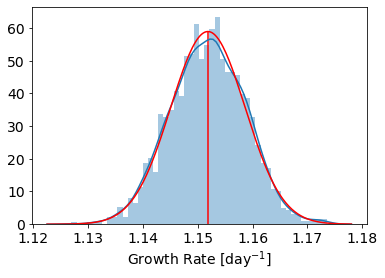

In [24]:
smp = samples['beta_grp_mean']/samples['gamma_grp_mean']
mn, std = norm.fit(smp)
sns.distplot(smp, bins=50, fit=norm, fit_kws={'color':'red'})
plt.vlines(mn, 0, norm.pdf(mn, mn, std), 'r')

plt.xlabel(r'$R_0$ [infections/person]')

# Typical time to removal for all regions together

Text(0.5, 0, 'Growth Rate [day$^{-1}$]')

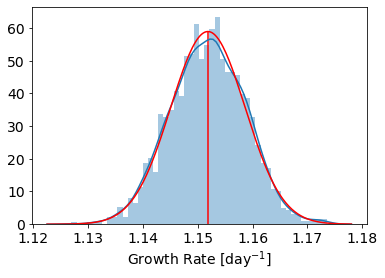

In [24]:
smp = 1.0/samples['gamma_grp_mean']
mn, std = norm.fit(smp)
sns.distplot(smp, bins=50, fit=norm, fit_kws={'color':'red'})
plt.vlines(mn, 0, norm.pdf(mn, mn, std), 'r')

plt.xlabel(r'Typical time to removal [days]')

# Growth rates for each region

Text(0.5, 0, 'Growth Rate [day$^{-1}$]')

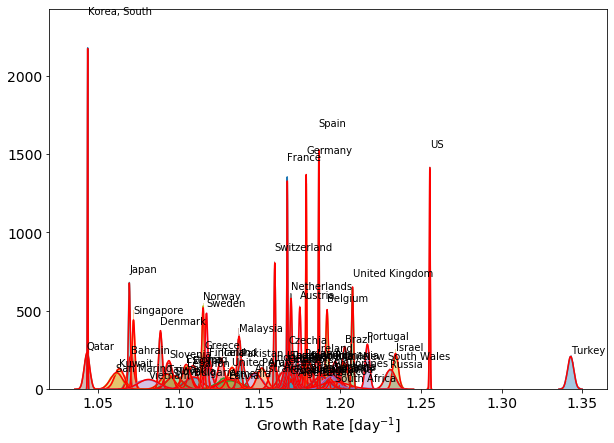

In [25]:
plt.figure(figsize=(10,7))
l_b, u_b = 1.0, 1.4

for i in range(N):
    smp = samples['r_ind'][:,i]
    mn, std = norm.fit(smp)
    sns.distplot(smp, bins=50, fit=norm, fit_kws={'color':'red'})
    plt.text(mn, 1.1*norm.pdf(mn, mn, std), list(cases.keys())[i], fontsize=10)

plt.xlabel(r'Growth Rate [day$^{-1}$]')
# plt.xlim(l_b, u_b)